In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pingouin as pg
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests
import warnings

warnings.simplefilter('ignore')

# set fonts for easy illustrator editing
plt.rcParams.update({
    'pdf.fonttype': 42,
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
})

## Read in data

In [9]:
# read data for pnd30 and pnd90
xls_path = '/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/data/LONGC3_DCh_ROIvalues.xlsx'
df_30 = pd.read_excel(xls_path, sheet_name='ses-PND30_median_FA')
df_90 = pd.read_excel(xls_path, sheet_name='ses-PND90_median_FA')

# column cleanup
df_30 = df_30.rename(columns=lambda x: x.replace(' ', '_'))
df_90 = df_90.rename(columns=lambda x: x.replace(' ', '_'))
df_30['subject'] = df_30['subject'].str.replace('sub-', '')
df_90['subject'] = df_90['subject'].str.replace('sub-', '')


## Preproccesing

In [10]:
# only keep white matter + subject columns
wm_cols = [
    'subject', 'arbor_vitae', 'stria_terminalis_tracts', 'cerebellar_white_matter',
    'diagonal_band', 'fiber_tracts', 'fimbria_fornix', 'internal_capsule',
    'midbrain_white_matter', 'olfactory_tracts', 'optic_tract', 'white_matter',
    'corpus_callosum'
]
df_30 = df_30[wm_cols].set_index('subject')
df_90 = df_90[wm_cols].set_index('subject')

# melt both to long format for merging and plotting
df_30_long = df_30.reset_index().melt(id_vars='subject', var_name='wm_area', value_name='wm_area_value_PND30')
df_90_long = df_90.reset_index().melt(id_vars='subject', var_name='wm_area', value_name='wm_area_value_PND90')

# merge both time points
combined_df = pd.merge(df_30_long, df_90_long, on=['subject', 'wm_area'])



In [12]:
# add sex and genotype labels
demographics = pd.read_excel('/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/data/Cohort1_demographics.xlsx')
combined_df['Sex'] = combined_df['subject'].map(demographics.set_index('Animal_ID')['Sex'])
combined_df['Genotype'] = combined_df['subject'].map(demographics.set_index('Animal_ID')['Genotype'])

# compute change between time points (pnd90 - pnd30)
combined_df['change'] = combined_df['wm_area_value_PND90'] - combined_df['wm_area_value_PND30']
combined_df.head(1)

,subject,wm_area,wm_area_value_PND30,wm_area_value_PND90,Sex,Genotype,change
0,COMR194a,arbor_vitae,0.134636,0.190343,M,KO,0.055707


## Plotting

In [13]:
palette = {"WT": "#c0bec2", "KO": "#915e95"}

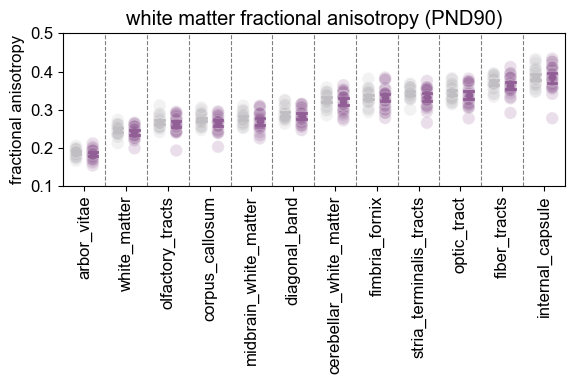

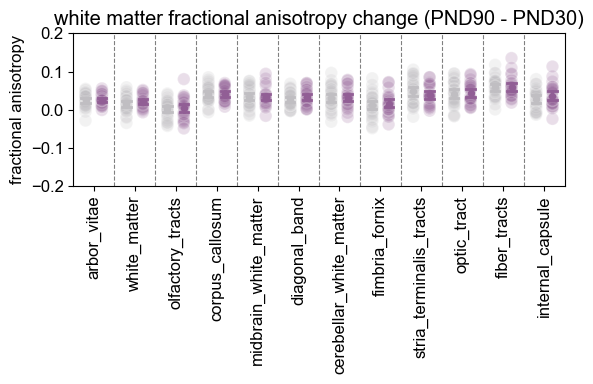

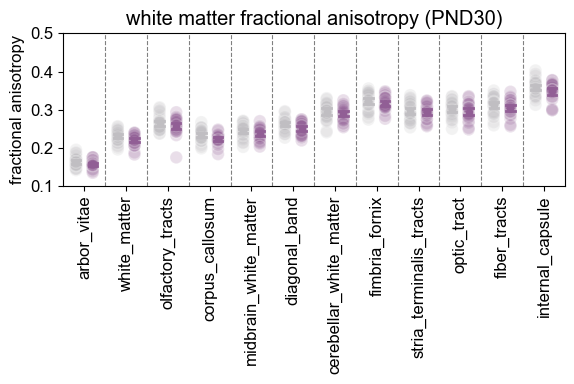

In [16]:
def plot_fa_box(df, value_col, title, save_path):
    plt.figure(figsize=(6, 4))
    hue_order = ['WT', 'KO']
    palette = {"WT": "#c0bec2", "KO": "#915e95"}

    sns.stripplot(
        x='wm_area', y=value_col, hue='Genotype', legend=False,
        linewidth=1, edgecolor='white', size=9, alpha=0.2,
        hue_order=hue_order, data=df, palette=palette,
        jitter=False, dodge=0.4, zorder=0
    )
    sns.pointplot(
        x='wm_area', y=value_col, hue='Genotype', hue_order=hue_order,
        data=df, dodge=0.4, markers='o', linestyles='-', errwidth=2,
        palette=palette, ci=95, capsize=0.2, scale=0.6, join=False
    )
    wm_areas = df['wm_area'].unique()
    for i in range(len(wm_areas) - 1):
        plt.axvline(x=i + 0.5, color='gray', linestyle='--', linewidth=0.8)
    plt.title(title)
    plt.xlabel('')
    plt.ylabel('fractional anisotropy')
    plt.xticks(ticks=range(len(wm_areas)), labels=wm_areas, rotation=90)

    if value_col == 'change':
        plt.ylim(-0.2, 0.2)
    else:
        plt.ylim(0.1, 0.5)
    plt.gca().get_legend().remove()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)


# plot fa at pnd90
plot_fa_box(
    combined_df,
    value_col='wm_area_value_PND90',
    title='white matter fractional anisotropy (PND90)',
    save_path='/Users/hannalemmik/Dropbox/KO_paper/FA/90_FA_combined.pdf'
)
# plot fa change (pnd90 - pnd30)
plot_fa_box(
    combined_df,
    value_col='change',
    title='white matter fractional anisotropy change (PND90 - PND30)',
    save_path='/Users/hannalemmik/Dropbox/KO_paper/FA/90_30_FA_change.pdf'
)

# plot fa at pnd30
plot_fa_box(
    combined_df,
    value_col='wm_area_value_PND30',
    title='white matter fractional anisotropy (PND30)',
    save_path='/Users/hannalemmik/Dropbox/KO_paper/FA/30_FA_combined.pdf'
)

## Quick stats

In [ ]:
## test if FA increases with time in the wm as expected, correct for multiple comparisons and add effect size
def ttest_change_fdr(df):
    results = []
    for roi in df['wm_area'].unique():
        roi_changes = df[df['wm_area'] == roi]['change'].dropna()
        t_stat, p_val = ttest_1samp(roi_changes, 0)
        results.append({
            'ROI': roi,
            't stat': t_stat,
            'p val': p_val,
            'mean change': roi_changes.mean(),
            'n': len(roi_changes)
        })
    results_df = pd.DataFrame(results)
    # benjamini-hochberg adjustment
    results_df['p_fdr_bh'] = multipletests(results_df['p val'], method='fdr_bh')[1]
    # effect size (cohen's d)
    results_df['cohen_d'] = results_df.apply(
        lambda row: row['mean change'] / np.std(df[df['wm_area']==row['ROI']]['change'].dropna(), ddof=1)
        if row['n'] > 1 else np.nan,
        axis=1
    )
    return results_df

ttest_results = ttest_change_fdr(combined_df)
ttest_results

,ROI,t stat,p val,mean change,n,p_fdr_bh,cohen_d
0,arbor_vitae,11.365131,6.084178e-16,0.025283,55,2.433671e-15,1.532474
1,white_matter,6.968134,4.641470e-09,0.017981,55,5.569764e-09,0.939583
2,olfactory_tracts,0.968609,3.370589e-01,0.003320,55,3.370589e-01,0.130607
3,corpus_callosum,14.716027,1.526208e-20,0.040896,55,9.157248e-20,1.984309
4,midbrain_white_matter,10.001425,6.804246e-14,0.033271,55,1.166442e-13,1.348592
5,diagonal_band,10.369360,1.864412e-14,0.029014,55,3.728825e-14,1.398204
6,cerebellar_white_matter,8.491462,1.600846e-11,0.031543,55,2.401269e-11,1.144989
7,fimbria_fornix,3.521259,8.817137e-04,0.013497,55,9.618695e-04,0.474806
8,stria_terminalis_tracts,11.023615,1.940867e-15,0.044003,55,5.822602e-15,1.486424
9,optic_tract,10.766775,4.688388e-15,0.042838,55,1.125213e-14,1.451792


In [19]:
# mixed ANOVA using pingouin
anova_results = pg.mixed_anova(
    dv='wm_area_value_PND90',
    within='wm_area',
    between='Genotype',
    subject='subject',
    data=combined_df
)
anova_results


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Genotype,0.005424,1,53,0.005424,1.671740,0.201634,0.030578,NaN
1,wm_area,1.981235,11,583,0.180112,1259.116470,0.000000,0.959607,0.563643
2,Interaction,0.001280,11,583,0.000116,0.813269,0.626847,0.015113,NaN


In [20]:
# mixed ANOVA using pingouin
anova_results = pg.mixed_anova(
    dv='wm_area_value_PND30',
    within='wm_area',
    between='Genotype',
    subject='subject',
    data=combined_df
)
anova_results


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Genotype,0.009341,1,53,0.009341,3.404781,0.070598,0.060363,NaN
1,wm_area,1.632023,11,583,0.148366,1083.119773,0.000000,0.953350,0.552621
2,Interaction,0.001040,11,583,0.000095,0.690503,0.748227,0.012861,NaN


In [22]:
combined_df.columns

Index(['subject', 'wm_area', 'wm_area_value_PND30', 'wm_area_value_PND90',
       'Sex', 'Genotype', 'change'],
      dtype='object')

In [23]:
# mixed ANOVA using pingouin
anova_results = pg.mixed_anova(
    dv='change',
    within='wm_area',
    between='Genotype',
    subject='subject',
    data=combined_df
)
anova_results


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Genotype,0.000529,1,53,0.000529,0.107305,7.445238e-01,0.002021,NaN
1,wm_area,0.134923,11,583,0.012266,50.338238,2.891348e-77,0.487121,0.650776
2,Interaction,0.002872,11,583,0.000261,1.071601,3.819674e-01,0.019818,NaN
